# 2. Autoencoder

In [1]:
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

from data import *
from autoencoder import *

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

from tqdm import tqdm

df = pipeline()
time_steps = 48
y_time_steps = 12
datasets = samples(df, time_steps, y_time_steps)

/Users/alex/prog/uber-time-series/data.py:98: FutureWarning: DatetimeIndex.strides is deprecated and will be removed in a future version
  strides = (df.index.strides[0],df.index.strides[0]*time_steps)


## Train autoencoder

### Set up

In [2]:
batch_size = 256
learning_rate = 0.001

model = Autoencoder()
train_dataloader = DataLoader(TrafficDataset(datasets,set_='train'),
                              batch_size=batch_size,
                              shuffle=True)
optimiser = optim.Adam(lr=learning_rate,
                       params=model.parameters())

In [3]:
losses = []

### Training loop

In [4]:
num_epochs = 100
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    for i, (x,y) in enumerate(train_dataloader):
        x_hat = model(x)
        
        optimiser.zero_grad()
        loss = F.mse_loss(y, x_hat)
        loss.backward()
        optimiser.step()
        
        step = (epoch * len(train_dataloader.dataset) +
                i * batch_size + len(x))
        losses.append([step, loss.item()])
        pbar.set_description("Epoch={0} | [{1:>5}|{2}]\t loss={3:.4f}"
                             .format(epoch,
                                     i * batch_size + len(x),
                                     len(train_dataloader.dataset),
                                     loss.item()))

Epoch=99 | [16559|16559]	 loss=0.0187: 100%|██████████| 100/100 [2:07:50<00:00, 76.70s/it]  


## Plot training loss after 100 epochs

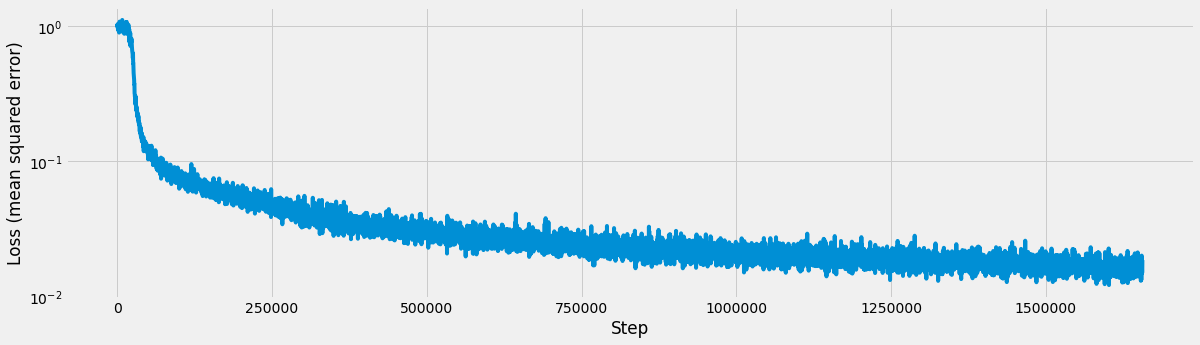

In [6]:
fig = plt.figure(figsize=(18,5))
ax  = fig.add_subplot(1,1,1)
_   = ax.plot(*np.array(losses)[:].T,label='training loss')
_   = ax.set_ylabel('Loss (mean squared error)')
_   = ax.set_xlabel('Step')
_   = ax.set_yscale('log')

## Plot predictions after 64 epochs

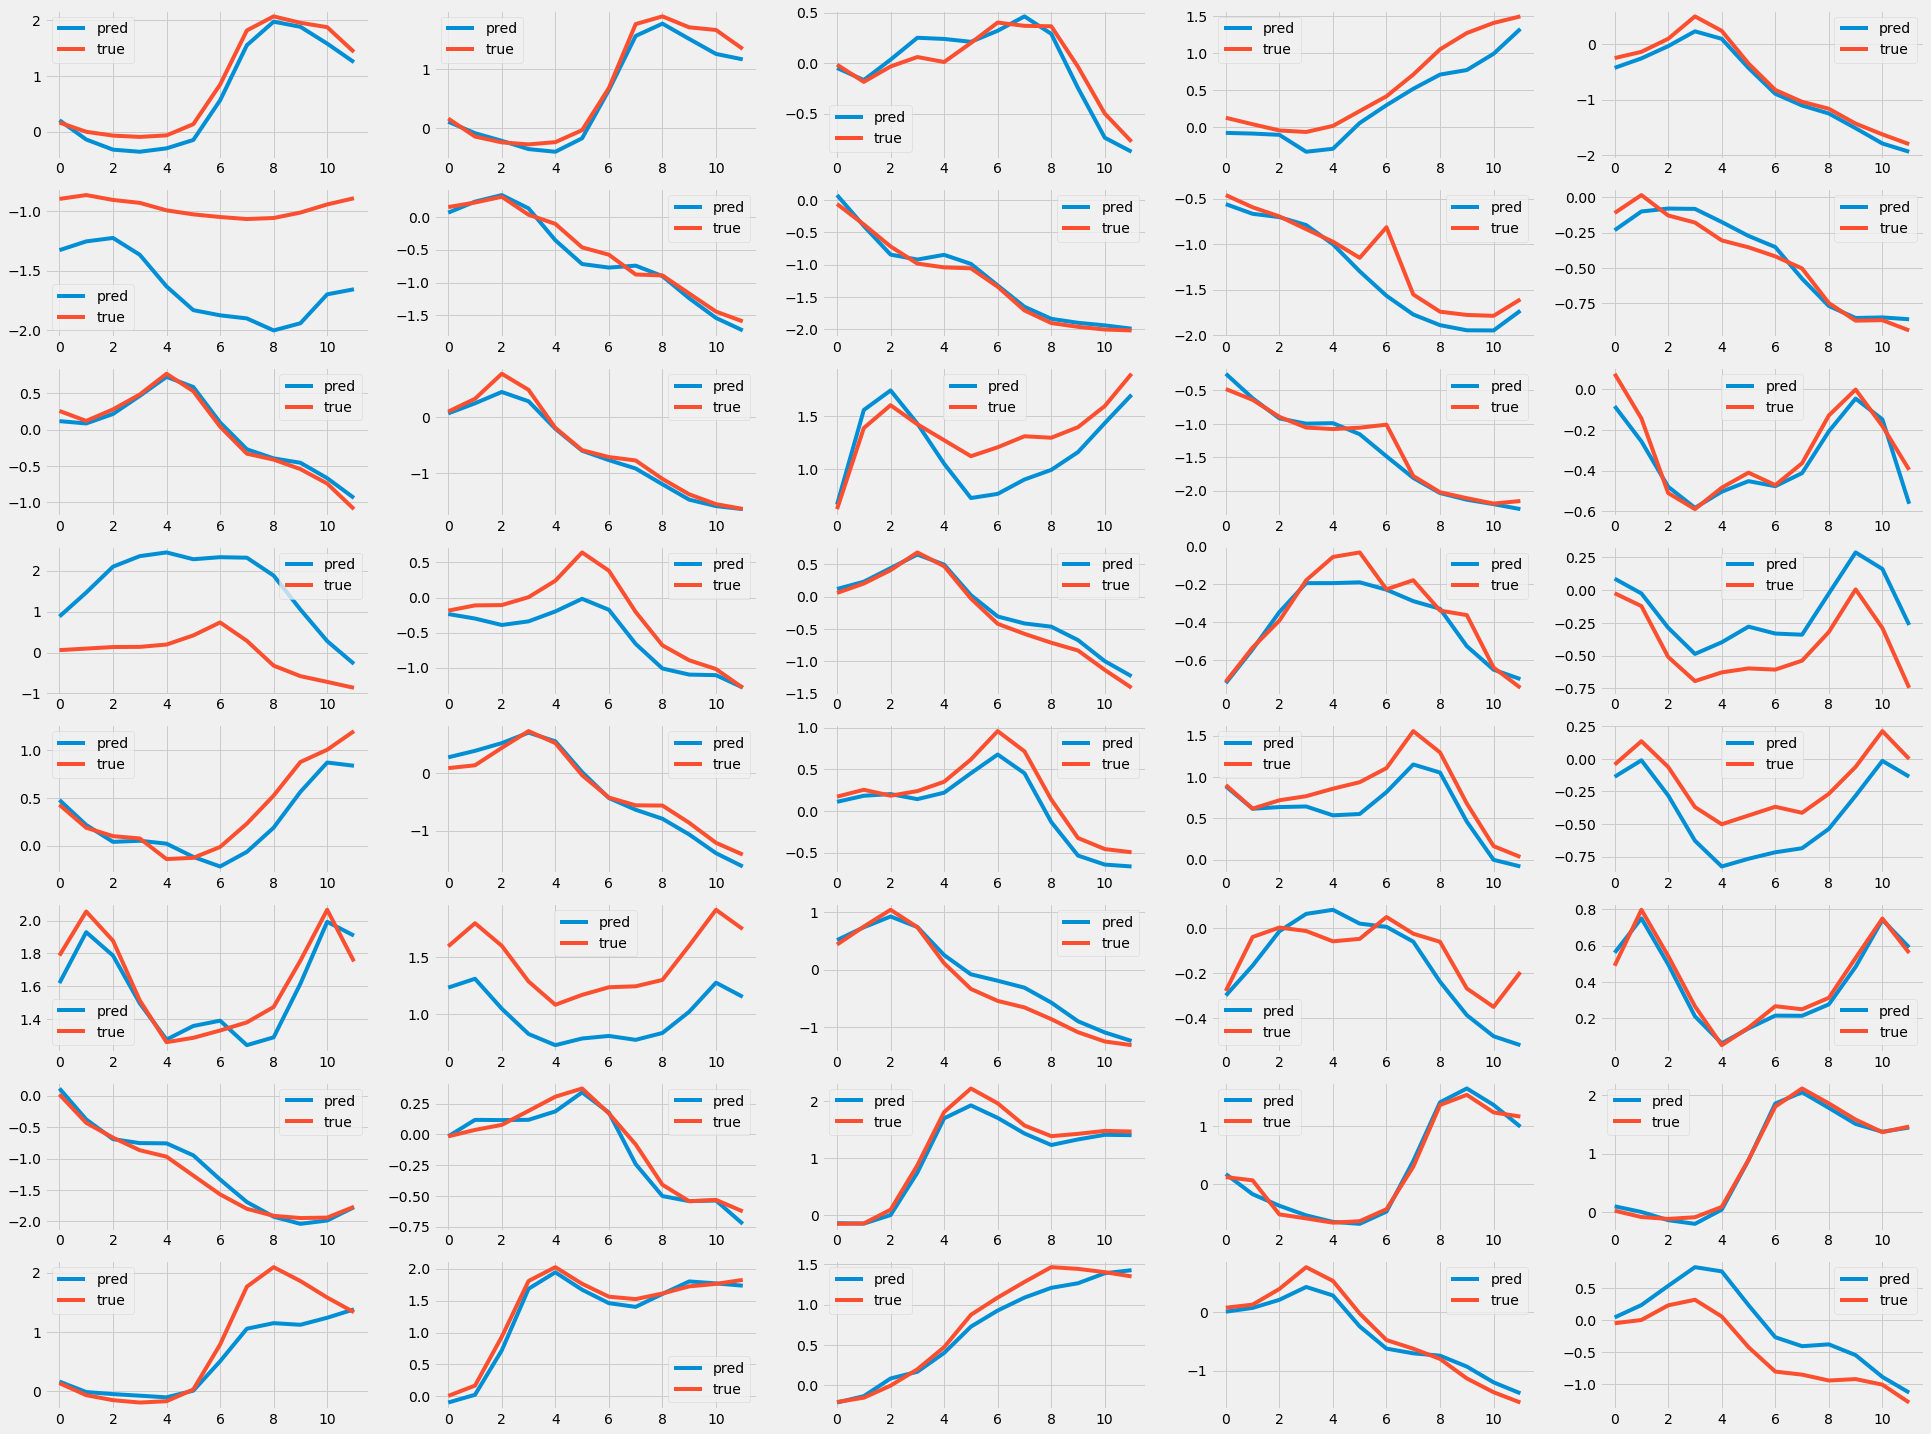

In [7]:
test_data = TrafficDataset(datasets, set_='test')
test_dataloader = DataLoader(test_data,
                             batch_size=len(test_data),
                             shuffle=True)
for x,y in test_dataloader:
    break

fig = plt.figure(figsize=(6*5,3*8))
x_pred = model(x).detach().numpy()
for i in range(40):
    ax = fig.add_subplot(8,5,i+1)
    ax.plot(x_pred[i],label='pred')
    ax.plot(y[i,:].numpy(),label='true')
    ax.legend()

## Save

In [8]:
torch.save(model,'saved_models/autoencoder.pt')